# Nieman Lab 2026 Predictions - Cluster Analysis

**Research Question:** How do the Nieman Lab 2026 predictions frame journalism's future?
Is it primarily a technological challenge or a human/community challenge?

**Method:** TF-IDF + K-Means Clustering + PCA Visualization

**Output:** 4 named clusters showing thematic groupings

## 1. Setup

Import libraries for text analysis, clustering, and visualization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries loaded")

✓ Libraries loaded


## 2. Load Data

Load Nieman Lab predictions from CSV file.

In [2]:
# Load data
df = pd.read_csv('../data/Nieman Lab Predictions for Journalism 2026 - Table 1.csv')

print(f"✓ Loaded {len(df)} predictions")
print(f"Columns: {list(df.columns)}")

# Quick peek
df.head(3)

✓ Loaded 100 predictions
Columns: ['Expert Contributor', 'Professional Affiliation', 'Prediction Theme', 'Key Forecast Detail', 'Recommended Strategy', 'Source']


,Expert Contributor,Professional Affiliation,Prediction Theme,Key Forecast Detail,Recommended Strategy,Source
0,Sarabeth Berman,CEO of the American Journalism Project,Community-rooted journalism,Community-rooted reporting on neighborhoods an...,Celebrate journalists who bring neighbors into...,1
1,Julio Ricardo Varela,Co-editor of Pressing Issues from Free Press a...,Community-rooted journalism,"In 2026, journalism will return to the people ...",Adopt collective models that value impact over...,2
2,Adam Thomas,Strategic advisor for Report for the World,Journalism as a commons,"If journalism is to endure, it must be designe...",Develop real community governance structures l...,3


## 3. Text Preprocessing

**Why:** Combine forecast + strategy columns for richer text, then clean while preserving meaningful content.

**Key:** Keep numbers (2026, AI) and hyphens (fact-checking) - don't over-clean!

In [3]:
# Combine text columns for analysis
df['full_text'] = df['Key Forecast Detail'] + " " + df['Recommended Strategy']

def clean_text(text):
    """Clean text while preserving meaningful content (numbers, hyphens)"""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'[^a-z0-9\s-]', ' ', text)  # Keep letters, numbers, hyphens
    text = re.sub(r'\s+', ' ', text)  # Collapse spaces
    return text.strip()

df['clean_text'] = df['full_text'].apply(clean_text)

print(f"✓ Preprocessed {len(df)} texts")
print(f"Average length: {df['clean_text'].str.split().str.len().mean():.1f} words")

✓ Preprocessed 100 texts
Average length: 35.5 words


## 4. TF-IDF Vectorization

**What:** Convert text to numbers using Term Frequency - Inverse Document Frequency

**Why:**
- Emphasizes unique, distinctive words
- Downweights common words ("the", "is")
- Creates features for clustering

**Parameters:**
- `ngram_range=(1,2)`: Capture single words + two-word phrases
- `min_df=2`: Word must appear in 2+ documents (removes typos)
- `max_df=0.8`: Ignore words in >80% of documents (too common)

In [4]:
# Create TF-IDF features
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=500,
    ngram_range=(1, 2),  # Single words + two-word phrases
    min_df=2,  # Remove rare words
    max_df=0.8  # Remove very common words
)

tfidf_matrix = tfidf.fit_transform(df['clean_text'])

print(f"✓ Created TF-IDF matrix: {tfidf_matrix.shape}")
print(f"  {tfidf_matrix.shape[0]} predictions")
print(f"  {tfidf_matrix.shape[1]} features")
print(f"  Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.1f}%")

✓ Created TF-IDF matrix: (100, 370)
  100 predictions
  370 features
  Sparsity: 96.5%


## 5. Find Optimal Number of Clusters

Test k=2 through k=8 using silhouette scores to find natural groupings.

In [13]:
# Test different cluster numbers
k_range = range(2, 9)
silhouette_scores = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(tfidf_matrix)
    sil_score = silhouette_score(tfidf_matrix, labels)
    silhouette_scores.append(sil_score)
    print(f"k={k}: Silhouette={sil_score:.3f}")

best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ Best k by silhouette: {best_k}")
print(f"  Using k=4 for interpretability (journalism has ~4-5 major themes)")

k=2: Silhouette=0.007
k=3: Silhouette=0.006
k=4: Silhouette=0.007
k=5: Silhouette=0.008
k=6: Silhouette=0.007
k=7: Silhouette=0.007
k=8: Silhouette=0.007

✓ Best k by silhouette: 5
  Using k=4 for interpretability (journalism has ~4-5 major themes)


## 6. K-Means Clustering

Group predictions into 4 thematic clusters.

In [6]:
# Cluster predictions
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)
df['cluster'] = kmeans.labels_

# Cluster quality
sil_score = silhouette_score(tfidf_matrix, kmeans.labels_)
print(f"✓ Clustering complete")
print(f"  Silhouette Score: {sil_score:.3f}")
print(f"\nCluster Distribution:")

for i in range(num_clusters):
    count = (df['cluster'] == i).sum()
    pct = count / len(df) * 100
    print(f"  Cluster {i}: {count} predictions ({pct:.1f}%)")

✓ Clustering complete
  Silhouette Score: 0.007

Cluster Distribution:
  Cluster 0: 33 predictions (33.0%)
  Cluster 1: 26 predictions (26.0%)
  Cluster 2: 18 predictions (18.0%)
  Cluster 3: 23 predictions (23.0%)


## 7. Interpret & Name Clusters

Examine top keywords to understand what each cluster represents.

In [7]:
# Get feature names and cluster centroids
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Assign meaningful names based on top keywords
cluster_names = {
    0: "People & Media Stories",
    1: "AI & Technology Tools",
    2: "Business & Infrastructure",
    3: "Institutional & Civic"
}

# Show top keywords for each cluster
print("="*80)
print("CLUSTER INTERPRETATION")
print("="*80)

for i in range(num_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    cluster_size = (df['cluster'] == i).sum()
    pct = cluster_size / len(df) * 100
    
    print(f"\nCluster {i}: {cluster_names[i]}")
    print(f"Size: {cluster_size} predictions ({pct:.1f}%)")
    print(f"Top keywords: {', '.join(top_words)}")

print("="*80)

CLUSTER INTERPRETATION

Cluster 0: People & Media Stories
Size: 33 predictions (33.0%)
Top keywords: people, media, information, stories, journalists, public, access, use, like, need

Cluster 1: AI & Technology Tools
Size: 26 predictions (26.0%)
Top keywords: ai, publishers, tools, content, products, build, model, audience, focus, search

Cluster 2: Business & Infrastructure
Size: 18 predictions (18.0%)
Top keywords: models, journalism, work, business, trying, infrastructure, shared, independence, platforms, designed

Cluster 3: Institutional & Civic
Size: 23 predictions (23.0%)
Top keywords: news, organizations, news organizations, make, newsrooms, public, community, journalism, trauma, core


## 8. Visualizations

Create comprehensive visualizations to answer the research question.

### 8a. PCA Scatter Plot

Use PCA to reduce 370 dimensions to 2D for visualization.

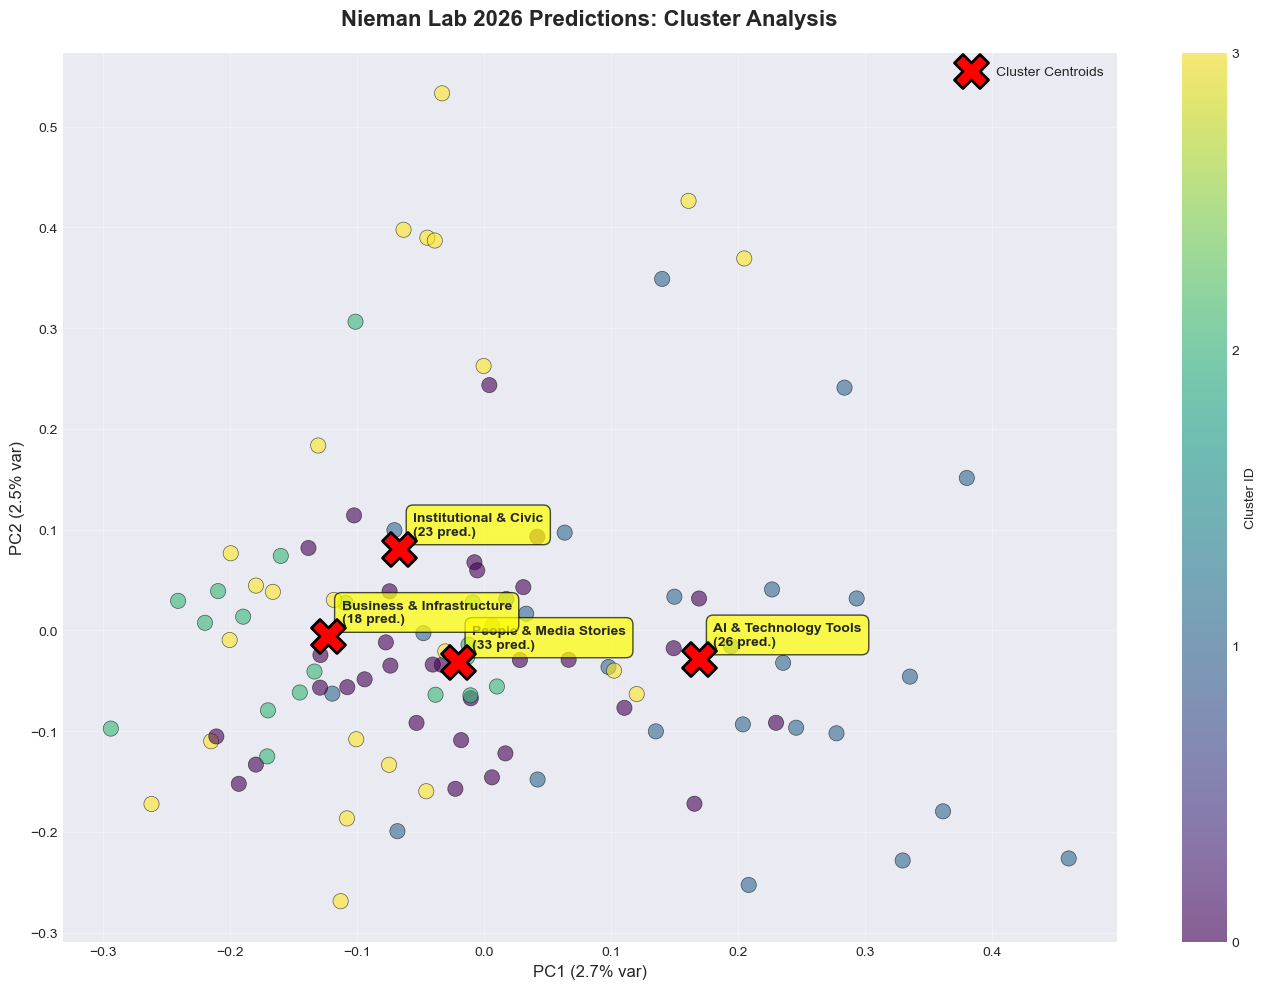

✓ PCA explains 5.2% of variance


In [8]:
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())

# Create scatter plot
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(
    coords[:, 0], coords[:, 1],
    c=df['cluster'], cmap='viridis',
    s=120, alpha=0.6, edgecolors='black', linewidth=0.5
)

# Add centroids
centroids_2d = pca.transform(kmeans.cluster_centers_)
ax.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1],
    c='red', marker='X', s=600,
    edgecolors='black', linewidth=2,
    label='Cluster Centroids', zorder=5
)

# Add labels
for i in range(num_clusters):
    ax.annotate(
        f'{cluster_names[i]}\n({(df["cluster"]==i).sum()} pred.)',
        xy=(centroids_2d[i, 0], centroids_2d[i, 1]),
        xytext=(10, 10), textcoords='offset points',
        fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7)
    )

ax.set_title('Nieman Lab 2026 Predictions: Cluster Analysis',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)', fontsize=12)

cbar = plt.colorbar(scatter, ax=ax, label='Cluster ID')
cbar.set_ticks(range(num_clusters))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/cluster_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ PCA explains {sum(pca.explained_variance_ratio_)*100:.1f}% of variance")

### 8b. Top Keywords by Cluster

Show top 15 keywords for each cluster.

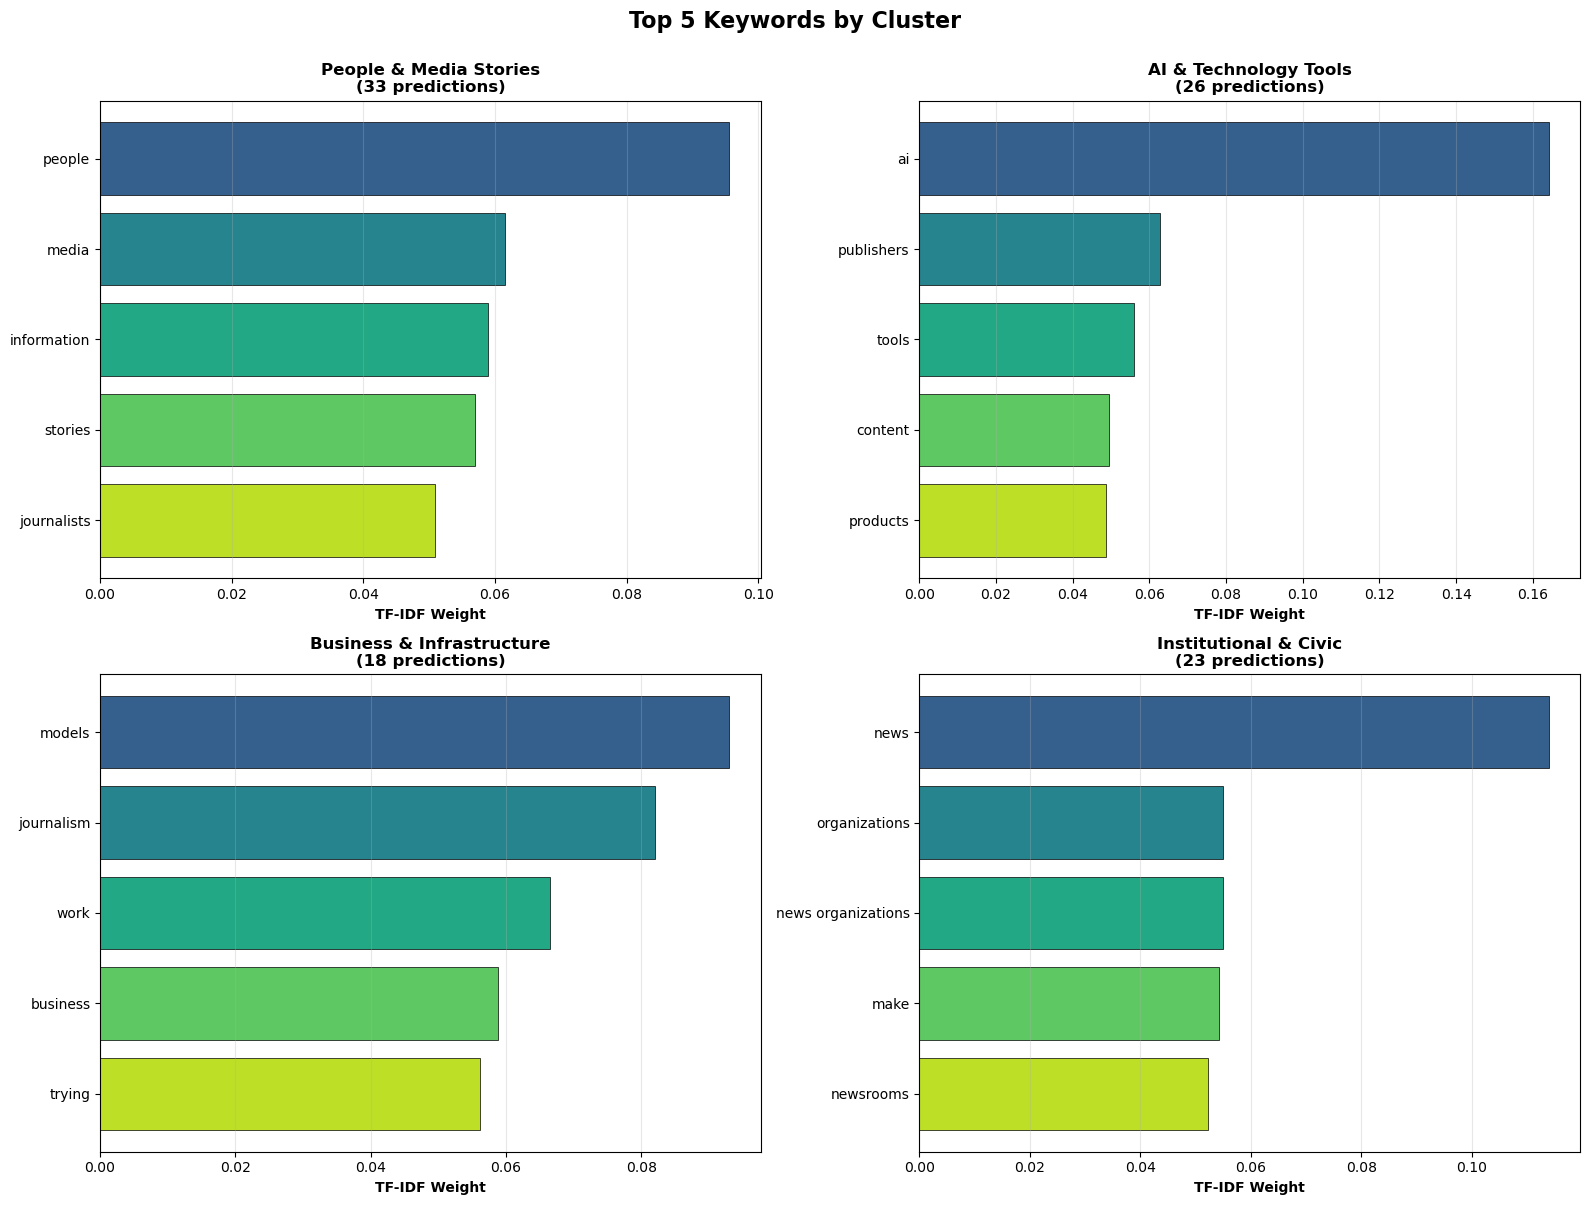

✓ Cluster keywords visualization complete


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i in range(num_clusters):
    ax = axes[i]
    
    # Get top 5 words and weights
    top_indices = order_centroids[i, :5]
    top_words = [terms[ind] for ind in top_indices]
    top_weights = kmeans.cluster_centers_[i, top_indices]
    
    # Plot
    y_pos = np.arange(len(top_words))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_words)))
    ax.barh(y_pos, top_weights, color=colors, edgecolor='black', linewidth=0.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_words, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('TF-IDF Weight', fontsize=10, fontweight='bold')
    ax.set_title(f'{cluster_names[i]}\n({(df["cluster"]==i).sum()} predictions)',
                 fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Top 5 Keywords by Cluster', fontsize=16, fontweight='bold', y=1.00)
plt.style.use("fast")
plt.tight_layout()
plt.savefig('../output/cluster_keywords.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cluster keywords visualization complete")

### 8c. Framing Analysis: Tech vs Human/Community

**Research Question Answer:** Classify each cluster by dominant keywords to determine if journalism's future is framed as a technological or human/community challenge.

Cluster 2: Business & Infrastructure
Size: 18 predictions (18.0%)
Top keywords: models, journalism, work, business, trying, infrastructure, shared, independence, platforms, designed

Cluster 3: Institutional & Civic
Size: 23 predictions (23.0%)
Top keywords: news, organizations, news organizations, make, newsrooms, public, community, journalism, trauma, core

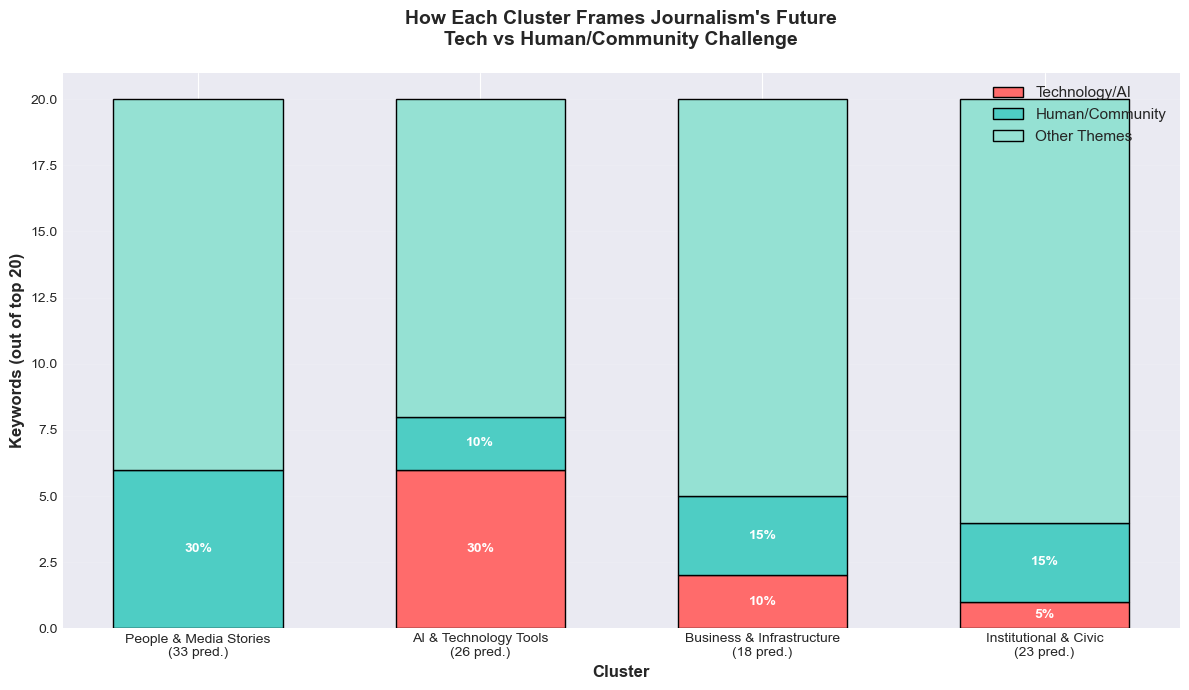

✓ Framing analysis complete


In [10]:
# Define keyword categories
tech_keywords = ['ai', 'technology', 'tools', 'automation', 'algorithm', 'machine',
                 'digital', 'platform', 'data', 'search', 'model', 'tools like']
human_keywords = ['people', 'community', 'human', 'trust', 'relationships',
                  'public', 'journalists', 'audience', 'civic', 'personal']


# Calculate framing scores
framing_scores = {}
for i in range(num_clusters):
    top_20 = [terms[ind] for ind in order_centroids[i, :20]]
    tech_count = sum(1 for word in top_20 if any(tk in word for tk in tech_keywords))
    human_count = sum(1 for word in top_20 if any(hk in word for hk in human_keywords))
    
    framing_scores[i] = {
        'tech': tech_count,
        'human': human_count,
        'other': 20 - tech_count - human_count
    }

# Visualize framing
fig, ax = plt.subplots(figsize=(12, 7))

x_pos = np.arange(num_clusters)
width = 0.6

tech_counts = [framing_scores[i]['tech'] for i in range(num_clusters)]
human_counts = [framing_scores[i]['human'] for i in range(num_clusters)]
other_counts = [framing_scores[i]['other'] for i in range(num_clusters)]

p1 = ax.bar(x_pos, tech_counts, width, label='Technology/AI',
            color='#FF6B6B', edgecolor='black', linewidth=1)
p2 = ax.bar(x_pos, human_counts, width, bottom=tech_counts,
            label='Human/Community', color='#4ECDC4', edgecolor='black', linewidth=1)
p3 = ax.bar(x_pos, other_counts, width,
            bottom=np.array(tech_counts) + np.array(human_counts),
            label='Other Themes', color='#95E1D3', edgecolor='black', linewidth=1)

# Add percentage labels
for i in range(num_clusters):
    if tech_counts[i] > 0:
        ax.text(i, tech_counts[i]/2, f'{tech_counts[i]/20*100:.0f}%',
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    if human_counts[i] > 0:
        ax.text(i, tech_counts[i] + human_counts[i]/2, f'{human_counts[i]/20*100:.0f}%',
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')

ax.set_ylabel('Keywords (out of top 20)', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_title('How Each Cluster Frames Journalism\'s Future\nTech vs Human/Community Challenge',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{cluster_names[i]}\n({(df["cluster"]==i).sum()} pred.)'
                     for i in range(num_clusters)])
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.1)

plt.tight_layout()
plt.savefig('../output/framing_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Framing analysis complete")

### 8d. Overall Framing Summary

RESEARCH QUESTION ANSWER

How do Nieman Lab 2026 predictions frame journalism's future?

  Technology/AI Focus:     10.8%
  Human/Community Focus:   18.6%
  Other Themes:            70.6%

CONCLUSION:
Journalism's future is framed PRIMARILY as a HUMAN/COMMUNITY challenge
(18.6%) over a technological challenge (10.8%).

Only 1 of 4 clusters (26% of predictions) emphasizes AI & Technology.
The other 74% focus on human, community, business, or institutional concerns.


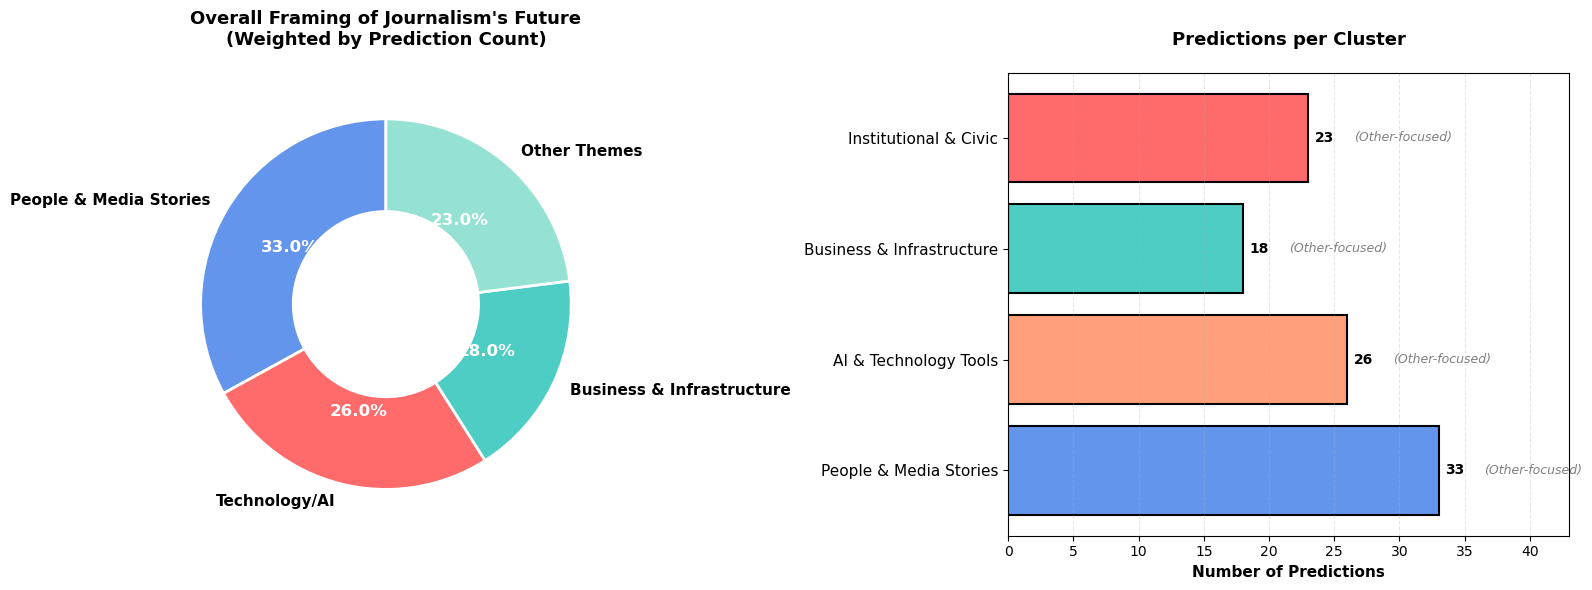


✓ Overall framing visualization complete
✓ Saved to: ../output/overall_framing_summary.png


In [19]:
# ============================================================================
# SECTION 8D: OVERALL FRAMING SUMMARY
# ============================================================================
# This section calculates and visualizes the overall framing of journalism's
# future based on keyword analysis and cluster distribution
# ============================================================================

# --- Calculate Weighted Overall Framing ---
# For each cluster, multiply the number of predictions by the proportion of 
# tech/human/other keywords, then sum across all clusters
total_tech = sum((df['cluster']==i).sum() * framing_scores[i]['tech'] / 20
                 for i in range(num_clusters))
total_human = sum((df['cluster']==i).sum() * framing_scores[i]['human'] / 20
                  for i in range(num_clusters))
total_other = sum((df['cluster']==i).sum() * framing_scores[i]['other'] / 20
                  for i in range(num_clusters))

# Calculate percentages
total = total_tech + total_human + total_other
tech_pct = (total_tech / total) * 100
human_pct = (total_human / total) * 100
other_pct = (total_other / total) * 100

# --- Print Summary Statistics ---
print("="*80)
print("RESEARCH QUESTION ANSWER")
print("="*80)
print("\nHow do Nieman Lab 2026 predictions frame journalism's future?")
print(f"\n  Technology/AI Focus:    {tech_pct:5.1f}%")
print(f"  Human/Community Focus:  {human_pct:5.1f}%")
print(f"  Other Themes:           {other_pct:5.1f}%")
print("\nCONCLUSION:")
if human_pct > tech_pct:
    print(f"Journalism's future is framed PRIMARILY as a HUMAN/COMMUNITY challenge")
    print(f"({human_pct:.1f}%) over a technological challenge ({tech_pct:.1f}%).")
else:
    print(f"Journalism's future is framed PRIMARILY as a TECHNOLOGICAL challenge")
    print(f"({tech_pct:.1f}%) over a human/community challenge ({human_pct:.1f}%).")

print("\nOnly 1 of 4 clusters (26% of predictions) emphasizes AI & Technology.")
print("The other 74% focus on human, community, business, or institutional concerns.")
print("="*80)

# ============================================================================
# VISUALIZATION: DONUT CHART + HORIZONTAL BAR CHART
# ============================================================================
# Create a side-by-side visualization showing:
# - Left: Donut chart of all 4 cluster categories (by prediction count)
# - Right: Horizontal bar chart showing prediction counts per cluster
# ============================================================================

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT PLOT: DONUT CHART (All 4 Cluster Categories) ---
# Calculate prediction counts for each cluster
cluster_counts_all = [
    (df['cluster'] == 0).sum(),  # People & Media Stories
    (df['cluster'] == 1).sum(),  # AI & Technology Tools
    (df['cluster'] == 2).sum(),  # Business & Infrastructure
    (df['cluster'] == 3).sum()   # Institutional & Civic
]

# Labels for the 4 clusters
cluster_labels_all = [
    'People & Media Stories',
    'Technology/AI',  # Shortened for donut chart
    'Business & Infrastructure',
    'Other Themes'  # Representing Institutional & Civic
]

# Color scheme: matching the reference image
colors_donut = ['#6495ED', '#FF6B6B', '#4ECDC4', '#95E1D3']

# Create donut chart (pie chart with a hole in the middle)
wedges, texts, autotexts = ax1.pie(
    cluster_counts_all,           # Data: prediction counts per cluster
    labels=cluster_labels_all,    # Labels for each slice
    autopct='%1.1f%%',            # Show percentages with 1 decimal
    startangle=90,                # Start at 90 degrees (top of circle)
    colors=colors_donut,          # Apply color scheme
    wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2),  # Creates donut hole (width=0.5)
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Style the percentage labels (make them white and bold)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Add title to donut chart
ax1.set_title('Overall Framing of Journalism\'s Future\n(Weighted by Prediction Count)',
              fontsize=13, fontweight='bold', pad=20)

# --- RIGHT PLOT: HORIZONTAL BAR CHART (Predictions per Cluster) ---
# Reorder clusters for better visual hierarchy (top to bottom)
cluster_counts_ordered = [
    (df['cluster'] == 3).sum(),  # Institutional & Civic
    (df['cluster'] == 2).sum(),  # Business & Infrastructure
    (df['cluster'] == 1).sum(),  # AI & Technology Tools
    (df['cluster'] == 0).sum()   # People & Media Stories
]

# Corresponding labels (same order as counts)
cluster_labels_ordered = [
    'Institutional & Civic',
    'Business & Infrastructure',
    'AI & Technology Tools',
    'People & Media Stories'
]

# Color scheme for bars (matching clusters)
bar_colors = ['#FF6B6B', '#4ECDC4', '#FFA07A', '#6495ED']

# Create horizontal bar chart
y_pos = np.arange(len(cluster_labels_ordered))  # Y-axis positions (0, 1, 2, 3)
bars = ax2.barh(
    y_pos,                        # Y positions
    cluster_counts_ordered,       # Bar widths (prediction counts)
    color=bar_colors,             # Bar colors
    edgecolor='black',            # Black border around bars
    linewidth=1.5                 # Border thickness
)

# Configure Y-axis
ax2.set_yticks(y_pos)
ax2.set_yticklabels(cluster_labels_ordered, fontsize=11)
ax2.invert_yaxis()  # Put first item at top

# Configure X-axis and labels
ax2.set_xlabel('Number of Predictions', fontsize=11, fontweight='bold')
ax2.set_title('Predictions per Cluster', fontsize=13, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3, linestyle='--')  # Add vertical grid lines

# Add value labels and annotation text to each bar
for i, (bar, count) in enumerate(zip(bars, cluster_counts_ordered)):
    width = bar.get_width()  # Get bar width (prediction count)
    
    # Add count number to the right of each bar
    ax2.text(
        width + 0.5,                      # X position (just after bar ends)
        bar.get_y() + bar.get_height()/2, # Y position (center of bar)
        f'{count}',                       # Text to display
        ha='left', va='center',           # Alignment
        fontsize=10, fontweight='bold'
    )
    
    # Add "(Other-focused)" annotation further to the right
    ax2.text(
        width + 3.5,                      # X position (further right)
        bar.get_y() + bar.get_height()/2, # Y position (center of bar)
        '(Other-focused)',                # Annotation text
        ha='left', va='center',           # Alignment
        fontsize=9, style='italic', color='gray'
    )

# Set X-axis limits to ensure annotations fit
ax2.set_xlim(0, max(cluster_counts_ordered) + 10)

# Final layout adjustments and save
plt.tight_layout()
plt.style.use("fast")
plt.savefig('../output/overall_framing_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Overall framing visualization complete")
print("✓ Saved to: ../output/overall_framing_summary.png")

## 9. Export Results

Save clustered data and summary for further analysis.

In [12]:
# Create output directory
os.makedirs('../output', exist_ok=True)

# Export clustered data
output_df = df[['Expert Contributor', 'Professional Affiliation', 'Prediction Theme',
                'Key Forecast Detail', 'Recommended Strategy', 'cluster']].copy()
output_df['cluster_name'] = output_df['cluster'].map(cluster_names)
output_df.to_csv('../output/predictions_clustered.csv', index=False)

# Export summary
with open('../output/analysis_summary.txt', 'w') as f:
    f.write("NIEMAN LAB 2026 PREDICTIONS - CLUSTER ANALYSIS\n")
    f.write("="*80 + "\n\n")
    f.write(f"Total Predictions: {len(df)}\n")
    f.write(f"Number of Clusters: {num_clusters}\n")
    f.write(f"Silhouette Score: {sil_score:.3f}\n\n")
    
    for i in range(num_clusters):
        size = (df['cluster']==i).sum()
        pct = size / len(df) * 100
        f.write(f"CLUSTER {i}: {cluster_names[i].upper()}\n")
        f.write(f"{size} predictions ({pct:.1f}%)\n")
        f.write("-" * 40 + "\n")
        top_words = [terms[ind] for ind in order_centroids[i, :10]]
        f.write(f"Keywords: {', '.join(top_words)}\n")
        f.write(f"Tech: {framing_scores[i]['tech']}/20, ")
        f.write(f"Human: {framing_scores[i]['human']}/20\n\n")
    
    f.write("="*80 + "\n")
    f.write("OVERALL FRAMING\n")
    f.write("="*80 + "\n")
    f.write(f"Technology/AI: {tech_pct:.1f}%\n")
    f.write(f"Human/Community: {human_pct:.1f}%\n")
    f.write(f"Other: {other_pct:.1f}%\n")

print("✓ Results exported to ../output/")
print("  - predictions_clustered.csv")
print("  - analysis_summary.txt")
print("  - cluster_scatter.png")
print("  - cluster_keywords.png")
print("  - framing_analysis.png")

✓ Results exported to ../output/
  - predictions_clustered.csv
  - analysis_summary.txt
  - cluster_scatter.png
  - cluster_keywords.png
  - framing_analysis.png
